Examine firing rate changes from MAZE to reMAZE to assess the underlying mechanism for reduced place field specficity and reliability during reMAZE in the SD group

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sstats
import pingouin as pg
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()

### Calculate mean firing rates

In [3]:
# Calculate mean firing rates
neuron_type = "stable" # 'all' or 'stable'
fr_df = []
for ids, sess in enumerate(sessions):
    assert neuron_type in ("all", "stable")
    neurons_use = sess.neurons if neuron_type == "all" else sess.neurons_stable
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    fr_df_maze = neurons_use.time_slice(*maze).to_dataframe()
    fr_df_maze["session_type"] = "MAZE"
    
    fr_df_remaze = neurons_use.time_slice(*remaze).to_dataframe()
    fr_df_remaze["session_type"] = "reMAZE"

    delta_fr = fr_df_maze["mean_frate"] - fr_df_remaze["mean_frate"]
    fr_df_maze["delta_frate_maze_remaze"] = delta_fr
    fr_df_remaze["delta_frate_maze_remaze"] = np.nan
    
    fr_df_temp = pd.concat((fr_df_maze, fr_df_remaze), axis=0)
    fr_df_temp['neuron_id'] = fr_df_temp.index
    
    fr_df_temp["grp"] = sess.tag
    fr_df_temp["session"] = ids

    fr_df.append(fr_df_temp)
    
fr_df = pd.concat(fr_df, axis=0, ignore_index=True)
fr_df["nid_unique"] = fr_df.apply(lambda row: f"{row.session}_{row.neuron_id}", axis=1)
fr_df

Number of neurons: 123
Number of neurons: 123
Number of neurons: 249
Number of neurons: 249
Number of neurons: 99
Number of neurons: 99
Number of neurons: 95
Number of neurons: 95
Number of neurons: 95
Number of neurons: 95
Number of neurons: 66
Number of neurons: 66
Number of neurons: 185
Number of neurons: 185
Number of neurons: 62
Number of neurons: 62
Number of neurons: 49
Number of neurons: 49


,neuron_type,neuron_id,nspikes,mean_frate,session_type,delta_frate_maze_remaze,grp,session,nid_unique
0,pyr,0,777,0.211659,MAZE,0.125499,NSD,0,0_0
1,pyr,1,1994,0.543176,MAZE,-0.005908,NSD,0,0_1
2,mua,2,11173,3.043585,MAZE,0.579460,NSD,0,0_2
3,pyr,3,180,0.049033,MAZE,-0.058142,NSD,0,0_3
4,pyr,4,740,0.201580,MAZE,0.084198,NSD,0,0_4
...,...,...,...,...,...,...,...,...,...
2041,pyr,44,6841,1.760422,reMAZE,NaN,SD,8,8_44
2042,pyr,45,369,0.094956,reMAZE,NaN,SD,8,8_45
2043,pyr,46,6436,1.656202,reMAZE,NaN,SD,8,8_46
2044,pyr,47,98,0.025219,reMAZE,NaN,SD,8,8_47


### Load in place field data

In [13]:
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters
sigma2 = 1.5
height_thresh = 0.75
separate_run_dir = True

# Old, combined direction data with different speed and frate thresholds
# grp_savename = subjects.Group.basedir / f"placefield_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
grp_savename = subjects.Group.basedir / f"placefield_grp_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}_{run_flag}.csv"
stats_all_df = pd.read_csv(grp_savename, index_col=0)
stats_all_df["cell_id_unique"] = stats_all_df.apply(lambda row: f"{row.sid}_{row.cell_id}", axis=1)
stats_all_df["cell_id_unique_by_dir"] = stats_all_df.apply(lambda row: f"{row.sid}_{row.cell_id}_{row.direction}", axis=1)
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid,cell_id_unique,cell_id_unique_by_dir
0,7,0,3.0,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
1,7,1,0.7,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
2,7,2,0.5,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
3,9,0,0.3,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0,0_9,0_9_up
4,9,1,0.3,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0,0_9,0_9_up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,55,5,1.1,1.1,59.000000,2.262388,57.868831,60.131219,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7,7_55,7_55_down
5205,55,6,0.4,0.4,67.000000,2.974970,65.512044,68.487014,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7,7_55,7_55_down
5206,59,0,0.7,0.7,51.000000,2.395026,49.802487,52.197513,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7,7_59,7_59_down
5207,59,1,0.5,0.5,27.000000,2.793090,25.603455,28.396545,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7,7_59,7_59_down


### Plot mean FR for reMAZE vs MAZE

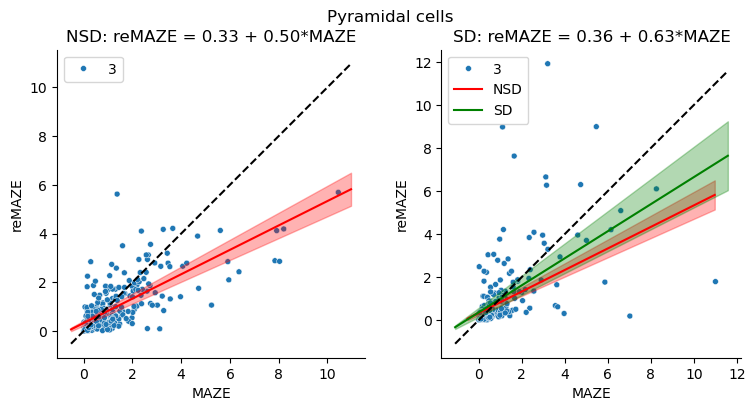

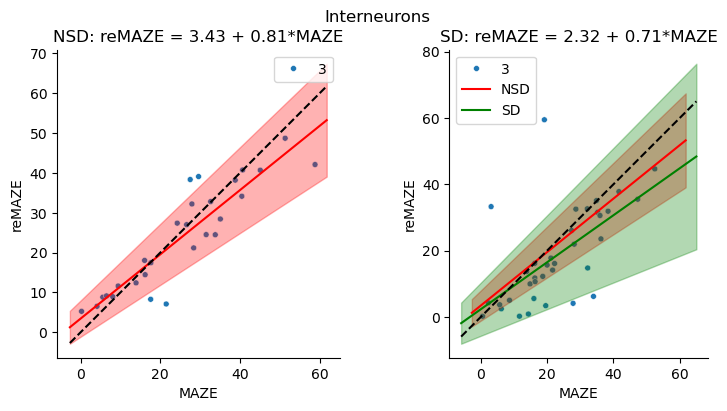

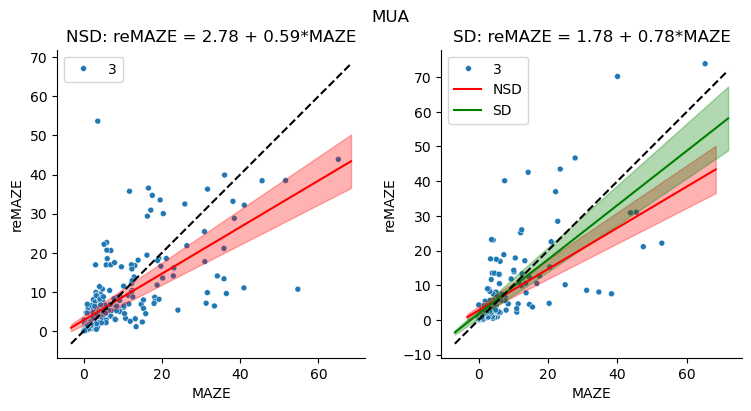

In [73]:
for ntype, nname in zip(["pyr", "inter", "mua"], ["Pyramidal cells", "Interneurons", "MUA"]):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle(nname)
    df_type = fr_df[fr_df.neuron_type == ntype]

    xlims_agg = []
    colors = ["r", "g"]
    for ida, (a, grp, color) in enumerate(zip(ax, ["NSD", "SD"], colors)):
        df_use = df_type[df_type.grp == grp]
        df_rs = df_use.pivot(columns="session_type", values="mean_frate", index="nid_unique")
        sns.scatterplot(data=df_rs,x="MAZE", y="reMAZE", size=3, ax=a)
        stats = pg.linear_regression(df_rs.MAZE, df_rs.reMAZE)
        if ida == 1:
            a.plot(xlims, xlims * slope + intercept, color=colors[0], label="NSD")
            a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=colors[0], alpha=0.3)
        intercept = stats[stats.names == "Intercept"].coef.values[0]
        slope = stats[stats.names == "MAZE"].coef.values[0]
        a.set_aspect('equal')
        xlims = np.array(a.get_xlim())
        # xlims = np.array(a.get_xlim()) if ida == 0 else xlims
        a.plot(xlims, xlims * slope + intercept, color, label="SD")
        intb = stats[stats.names == "Intercept"]["CI[2.5%]"].values[0]
        intt = stats[stats.names == "Intercept"]["CI[97.5%]"].values[0]
        mb = stats[stats.names == "MAZE"]["CI[2.5%]"].values[0]
        mt = stats[stats.names == "MAZE"]["CI[97.5%]"].values[0]
        a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=color, alpha=0.3)
        a.plot(xlims, xlims, 'k--')
        # a.set_xlim(xlims)
        # a.set_ylim(xlims)
        a.set_title(f"{grp}: reMAZE = {intercept:0.2f} + {slope:0.2f}*MAZE")
        if ida == 1:
            a.legend()
    sns.despine(fig=fig)

### Plot Peak FR for reMAZE vs. MAZE

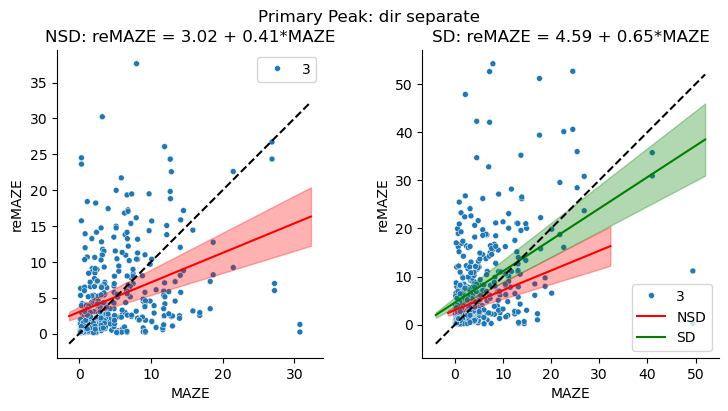

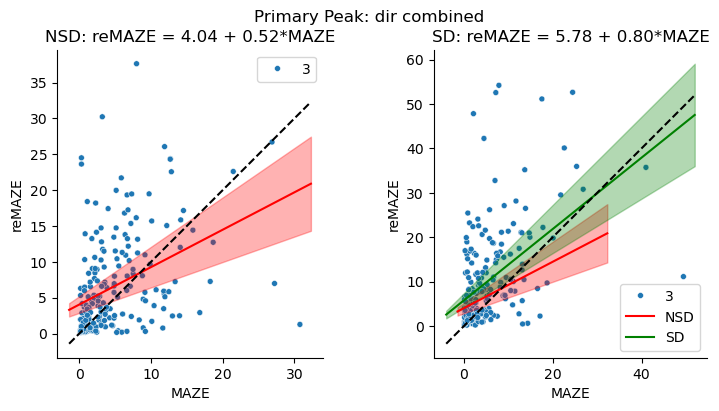

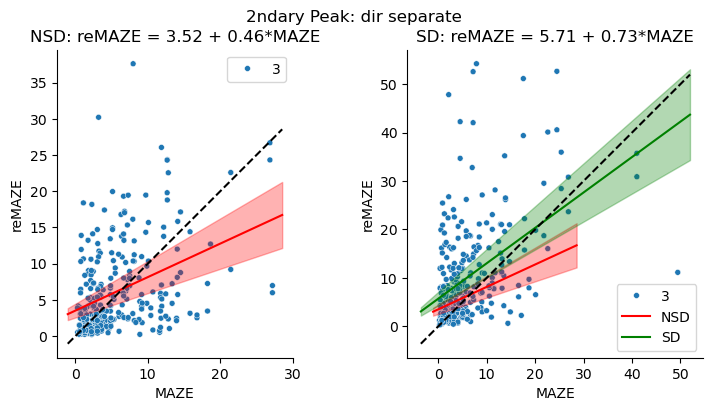

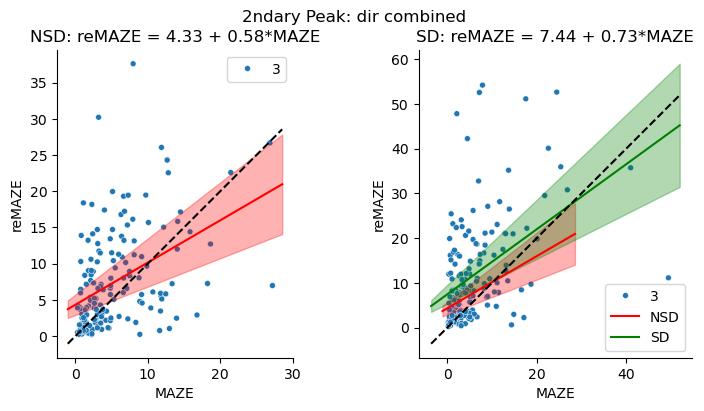

In [76]:
# direction = "separate" # "combined"
for peak in [0, 1]:
    assert peak in [0, 1]
    peak_type = "Primary" if peak == 0 else "2ndary"
    for direction in ["separate", "combined"]:
        assert direction in ["combined", "separate"]
        index_use = "cell_id_unique" if direction == "combined" else "cell_id_unique_by_dir"
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        fig.suptitle(f"{peak_type} Peak: dir {direction}")
        for ida, (a, grp, color) in enumerate(zip(ax, ["NSD", "SD"], colors)):
            df_peak = stats_all_df[stats_all_df.peak_no == peak]
            df_use = df_peak[df_peak.grp == grp]
            if direction == "combined":
                df_use = df_use.groupby(["cell_id_unique", "session"]).max().reset_index()
            df_rs = df_use.pivot(columns="session", values="FRmax", index=index_use)
            sns.scatterplot(data=df_rs,x="MAZE", y="reMAZE", size=3, ax=a)
            df_rs_clean = df_rs[~np.any(np.isnan(df_rs.values), axis=1)]
            stats = pg.linear_regression(df_rs_clean.MAZE, df_rs_clean.reMAZE)
            if ida == 1:
                a.plot(xlims, xlims * slope + intercept, color=colors[0], label="NSD")
                a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=colors[0], alpha=0.3)
            intercept = stats[stats.names == "Intercept"].coef.values[0]
            slope = stats[stats.names == "MAZE"].coef.values[0]
            a.set_aspect('equal')
            xlims = np.array(a.get_xlim())
            # xlims = np.array(a.get_xlim()) if ida == 0 else xlims
            a.plot(xlims, xlims * slope + intercept, color, label="SD")
            intb = stats[stats.names == "Intercept"]["CI[2.5%]"].values[0]
            intt = stats[stats.names == "Intercept"]["CI[97.5%]"].values[0]
            mb = stats[stats.names == "MAZE"]["CI[2.5%]"].values[0]
            mt = stats[stats.names == "MAZE"]["CI[97.5%]"].values[0]
            a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=color, alpha=0.3)
            # a.set_xlim(xlims)
            # a.set_ylim(xlims)
            a.plot(xlims, xlims, 'k--')
            if ida == 1:
                a.legend()
            a.set_title(f"{grp}: reMAZE = {intercept:0.2f} + {slope:0.2f}*MAZE")
        sns.despine(fig=fig)